In [1]:

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
import loading
import process_aravec
from gensim.models import Word2Vec
import os
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.layers import Input,Embedding, Conv1D,MaxPooling1D,GlobalMaxPooling1D, Dense,Dropout,LSTM,Flatten,GRU,Bidirectional,GlobalAveragePooling1D
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns             
from keras import regularizers
from keras.models import Model


/Users/xabuka/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [27]:
max_features = 5000
max_len = 20
training_samples = 8000  # We will be training on 200 samples
validation_samples = 2000  # We will be validating on 10000 samples
# Convolution
kernel_size = 5
filters = 64
pool_size = 2

# LSTM
lstm_output_size = 70
#keras model
epochs = 10
batch_size=50

#data directory
#data_dir = '../data/SplitedPalSent'
#data_dir = '../data/ASTD'
#data_dir = '../data/labr5/clean'
#data_dir = '../data/labr3'
#data_dir = '../data/labr2'
#data_dir = '../data/Shami'
train_dir = '../data/D6_26/6dialects/splited_train/BEI'
test_dir = '../data/D6_26/6dialects/splited_dev/BEI'



In [32]:
import loading
input_train, y_train  = loading.load_train(train_dir,max_len,training_samples,validation_samples,max_features, Validation = False, binary = False )
input_test, y_test = loading.load_test(test_dir,max_len,max_features,binary = False )
print(len(input_train))
print((y_train[10]))
print(input_test[1])




../data/D6_26/6dialects/splited_train/BEI/train
Found 8797 unique tokens.
Shape of data tensor: (9600, 20)
Shape of label tensor: (9600,)
9600
[1. 0. 0. 0. 0. 0.]
[ 66 934  94 935 642 112   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


In [29]:
def embedding_matrix(data_dir,max_len,max_features):
    ara_dir = '../data/tweet_cbow_300/'
    word_index = loading.word_index(data_dir,max_len,max_features)
    t_model = Word2Vec.load(os.path.join(ara_dir,'tweets_cbow_300'))

    print('Found %s word vectors.' % len(t_model.wv.index2word))# how many words in aravec this model
    embeddings_index = t_model.wv

    embedding_dim = embeddings_index.vector_size #300
    embedding_matrix = np.zeros((max_features, embedding_dim))

    for word, i in word_index.items():
        word = process_aravec.clean_str(word).replace(" ", "_")
        check = False
        if word in embeddings_index:
            w = word
            check = True
        elif word[1:] in embeddings_index:
            w= word[1:]
            check = True
        elif word[:-2] in embeddings_index:
            w= word[:-2]
            check = True
        if check:
            embedding_vector = embeddings_index[w]
            if i < max_features:
                if embedding_vector is not None:
                    # Words not found in embedding index will be all-zeros.
                    embedding_matrix[i] = embedding_vector
                    #print(len(embedding_vector))
       
        
    return  embedding_matrix  
embedding_matrix = embedding_matrix(train_dir,max_len,max_features)
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements / max_features)
#for dialetct PAl it only covers 35% of the vocabulary
# for MSA it covers 98%
#ASTD . 90%
#shami 67%

Found 331679 word vectors.
0.9656


#building model CNN + LSTM
#tried on ASTD 
model = Sequential()
model.add(Embedding(max_features, 100,weights=[embedding_matrix], trainable=True, input_length=max_len))
model.add(LSTM(70,dropout=0.5, recurrent_dropout=0.5))#,return_sequences=True)))
#model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(30))
#model.add(Dropout(0.5))
model.add(Dense(3,activation='sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics =['acc'])
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())



model = Sequential()
model.add(Embedding(max_features, 100,weights=[embedding_matrix], trainable=True, input_length=max_len))
#model.add(Flatten())
#model.add(Conv1D(100, 10, activation='relu'))
model.add(Conv1D(100, 10, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(160, 10, activation='relu'))
#model.add(Conv1D(160, 10, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics =['acc'])
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())


In [23]:
#LSTM  EXP 16
model=Sequential()
model.add(Embedding(max_features, 300,weights=[embedding_matrix], trainable=True, input_length=max_len)) 
model.add(Bidirectional(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True)))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6,activation='sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics =['acc'])
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 300)           3000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 20, 256)           439296    
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 606       
Total params: 3,528,578
Trainable params: 3,528,578
Non-trainable params: 0
_________________________________________________________________


In [30]:
#CNN_19,2


def create_convnet(max_features, vectore_d):
    input_shape = Input(shape=(max_features, vectore_d))
    conv = []
    for filters in [32,64,128]:
        for k_size in [2,3,4,5,6]:
            tower = Conv1D(filters, k_size, activation='relu')(input_shape)
            tower = GlobalMaxPooling1D()(tower)
            conv.append(tower)
    
    merged = layers.concatenate([tower for tower in conv], axis=1)
   
    
    out = Dense(10,activation='relu')(merged)
    #out = Dropout(0.3)(out)
    #out = Dense(30)(out)
    out = Dense(6, activation='sigmoid')(out)

    model = Model(input_shape, out)
    #print(model.summary())
    from keras.utils.vis_utils import plot_model
    #plot_model(model, to_file=filepath+'.png', show_shapes=True, show_layer_names=True)
    return model


input_shape =(max_features, )
model = Sequential()
model.add(Embedding(max_features, 300,weights=[embedding_matrix], trainable=True, input_length=max_len)) 
model.add(Bidirectional(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences= True)))
model.add(Bidirectional(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences= True)))
model.add(create_convnet(max_len, 128))



model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics =['acc'])
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 20, 300)           1500000   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 20, 256)           439296    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 20, 128)           164352    
_________________________________________________________________
model_3 (Model)              (None, 6)                 585836    
Total params: 2,689,484
Trainable params: 2,689,484
Non-trainable params: 0
_________________________________________________________________
None


#EXP LSTM 9+17
model=Sequential()
model.add(Embedding(max_features, 300,weights=[embedding_matrix], trainable=True, input_length=max_len)) 
model.add(Bidirectional(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True)))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())


#building model CNN + LSTM kagg
model = Sequential()
model.add(Embedding(max_features, 300,weights=[embedding_matrix], trainable=True, input_length=max_len)) 
model.add(Dropout(0.2))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(Dropout(0.2))
model.add(Conv1D(32, 3, padding='valid', activation='relu', strides=1))
#model.add(Flatten())
model.add(LSTM(lstm_output_size, dropout = 0.3, recurrent_dropout=0.3))
model.add(Dense(3,activation='sigmoid'))
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics =['acc'])
print(model.summary())   
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='weights/kaggle.png', show_shapes=True, show_layer_names=True)
    

In [37]:
#filepath="weights/weights.best.exp_16.hdf5"

#model.load_weights(filepath)
filepath="weights.best.exp_OOV.hdf5"

#saved_model = filepath
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
callbacks_list = [checkpoint,early_stopping]
history = model.fit(input_train, y_train,
                    epochs=100,
                    batch_size=50,
                    #validation_data=(x_val, y_val),
                    validation_split= 0.2,
                    callbacks=[checkpoint])#[early_stopping])


model.save_weights(filepath)   

Train on 7680 samples, validate on 1920 samples
Epoch 1/100
7680/7680 [==============================] - 45s 6ms/step - loss: 1.0359 - acc: 0.5382 - val_loss: 1.5343 - val_acc: 0.3974

Epoch 00001: val_loss improved from inf to 1.53432, saving model to weights.best.exp_OOV.hdf5
Epoch 2/100
7680/7680 [==============================] - 44s 6ms/step - loss: 1.0120 - acc: 0.5518 - val_loss: 1.5233 - val_acc: 0.4052

Epoch 00002: val_loss improved from 1.53432 to 1.52330, saving model to weights.best.exp_OOV.hdf5
Epoch 3/100
7680/7680 [==============================] - 44s 6ms/step - loss: 0.9629 - acc: 0.5651 - val_loss: 1.6471 - val_acc: 0.4151

Epoch 00003: val_loss did not improve from 1.52330
Epoch 4/100
7680/7680 [==============================] - 44s 6ms/step - loss: 0.9483 - acc: 0.5723 - val_loss: 1.6389 - val_acc: 0.4188

Epoch 00004: val_loss did not improve from 1.52330
Epoch 5/100
7680/7680 [==============================] - 45s 6ms/step - loss: 0.9227 - acc: 0.5849 - val_loss:

KeyboardInterrupt: 

# 'Testing And Evalaution'
1- classification report

In [34]:
def plot_show(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

#plot_show(history)
#filepath="weights/weights.best.exp16.hdf5"

model.load_weights(filepath)
#y_test.argmax(axis=1), predicte.argmax(axis=1)
scores= model.evaluate(input_test, y_test,verbose=0)
predicte = model.predict(input_test, verbose = 2, batch_size = batch_size)
print("Accuracy: %.2f%%" % (scores[1]*100))



#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file=filepath+'.png', show_shapes=True, show_layer_names=True)

Accuracy: 18.33%


In [35]:
#test and Evaluation
#model.load_weights(filepath)
#predicted = model.predict_proba(input_test, verbose = 2, batch_size = batch_size)
#for binary
#print(predicte)
#print(metrics.classification_report(y_test, np.round(predicte)))
#for multi-class
print(metrics.classification_report(y_test.argmax(axis=1), predicte.argmax(axis=1)))


              precision    recall  f1-score   support

           0       0.17      0.21      0.19       200
           1       0.20      0.34      0.25       200
           2       0.21      0.20      0.20       200
           3       0.14      0.14      0.14       200
           4       0.16      0.14      0.15       200
           5       0.23      0.07      0.11       200

   micro avg       0.18      0.18      0.18      1200
   macro avg       0.19      0.18      0.18      1200
weighted avg       0.19      0.18      0.18      1200



0.18333333333333332
Accuracy: 18.33%
[[42 60 29 35 27  7]
 [37 68 26 40 17 12]
 [46 36 39 37 36  6]
 [33 61 33 29 29 15]
 [41 57 32 33 27 10]
 [45 54 23 27 36 15]]


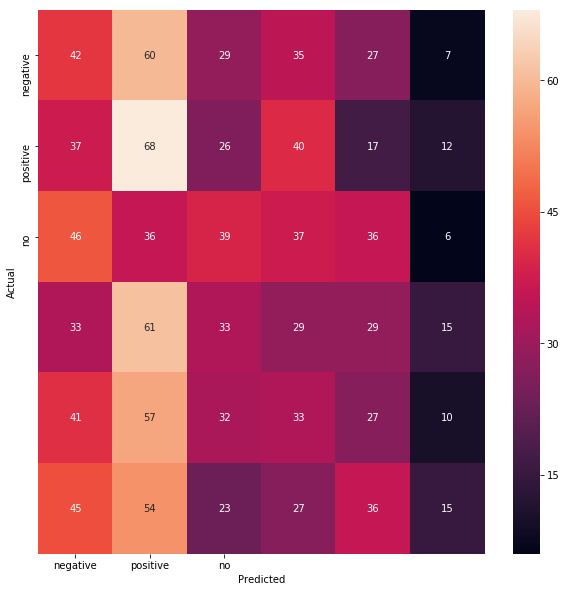

In [36]:
#predicted = np.argmax(predicted, axis=1)
#scores= model.evaluate(input_test, y_test,verbose=0)
#for binary
#print(metrics.accuracy_score(y_test, np.round(predicte)))
#conf_mat = metrics.confusion_matrix(y_test, np.round(predicte))
#for multi
print(metrics.accuracy_score(y_test.argmax(axis=1), predicte.argmax(axis=1)))
conf_mat = metrics.confusion_matrix(y_test.argmax(axis=1), predicte.argmax(axis=1))

print("Accuracy: %.2f%%" % (scores[1]*100))
print(conf_mat)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['negative','positive','no'], yticklabels=['negative','positive','no'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
#for x,y,p in zip(input_test,y_test,predicte):
 #   print(x,y,p)


In [ ]:
def create_convnet(max_features, vectore_d):
    input_shape = Input(shape=(max_features, vectore_d))
    tower_1 = Conv1D(64, 3, activation='relu')(input_shape)
    tower_1 = MaxPooling1D(5)(tower_1)
   # tower_1 = Flatten()(tower_1)

    tower_2 = Conv1D(64, 4, activation='relu')(input_shape)
    tower_2 = MaxPooling1D(4)(tower_2)
    #tower_2 = Flatten()(tower_2)

    tower_3 = Conv1D(64, 5, activation='relu')(input_shape)
    tower_3 = MaxPooling1D(3)(tower_3)
    #tower_3 = Flatten()(tower_3)
    
    tower_4 = LSTM(64,dropout=0.5, recurrent_dropout=0.5, return_sequences = True)(input_shape)
    tower_5 = LSTM(32,dropout=0.5, recurrent_dropout=0.5,return_sequences= False)(tower_4)
    #tower_4 = Dense(100, activation = 'relu')(tower_4)
    
    
    
    merged = layers.concatenate([tower_1, tower_2,tower_3], axis=1)
    merged = Flatten()(merged)
    
    final_merged = layers.concatenate([merged,tower_5],axis = 1)
    out = Dense(100,activation='relu')(final_merged)
    #out = Dropout(0.3)(out)
    out = Dense(30)(out)
    out = Dense(1, activation='sigmoid')(out)

    model = Model(input_shape, out)
    print(model.summary())
    from keras.utils.vis_utils import plot_model
    plot_model(model, to_file='weights/1CNN.png', show_shapes=True, show_layer_names=True)
    
    return model
create_convnet(max_features, 300)